In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("ratings_Electronics.csv",header=None,names=["userId","productId","ratings","timestamp"])

In [3]:
df.describe(include="all")

,userId,productId,ratings,timestamp
count,7824482,7824482,7.824482e+06,7.824482e+06
unique,4201696,476002,NaN,NaN
top,A5JLAU2ARJ0BO,B0074BW614,NaN,NaN
freq,520,18244,NaN,NaN
mean,NaN,NaN,4.012337e+00,1.338178e+09
std,NaN,NaN,1.380910e+00,6.900426e+07
min,NaN,NaN,1.000000e+00,9.127296e+08
25%,NaN,NaN,3.000000e+00,1.315354e+09
50%,NaN,NaN,5.000000e+00,1.361059e+09
75%,NaN,NaN,5.000000e+00,1.386115e+09


In [4]:
df.dtypes

userId        object
productId     object
ratings      float64
timestamp      int64
dtype: object

In [5]:
df.isnull().sum()

userId       0
productId    0
ratings      0
timestamp    0
dtype: int64

In [6]:
#dropping timestamp column as it is not needed for this recommendation
df=df.drop(columns=["timestamp"])

In [7]:
df.head()

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [8]:
df.shape

(7824482, 3)

(array([ 901765.,       0.,  456322.,       0.,       0.,  633073.,
              0., 1485781.,       0., 4347541.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

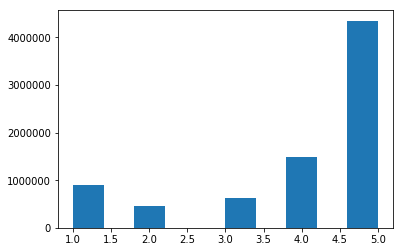

In [9]:
plt.hist(df['ratings'])

# 2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

In [10]:
df2=df.groupby('userId').nunique()
df3=df2[df2.iloc[:,1]>70]
df3.head(10)
#Selecting users who have rated atleast 70+ Products

,userId,productId,ratings
userId,,,
A100UD67AHFODS,1,116,5
A100WO06OQR8BQ,1,132,5
A105TOJ6LTVMBG,1,71,5
A10NMELR4KX0J6,1,96,5
A10O7THJ2O20AG,1,80,2
A10PEXB6XAQ5XF,1,107,5
A10X9ME6R66JDX,1,71,4
A10Y058K7B96C6,1,123,5
A10ZBR6O8S8OCY,1,77,3


In [11]:
df=df.set_index('userId') 
df=df[df.index.isin(df3.index)]
df.shape

(75352, 2)

In [12]:
df.head()

,productId,ratings
userId,,
AT09WGFUM934H,0594481813,3.0
A32HSNCNPRUMTR,0970407998,1.0
A17HMM1M7T9PJ1,0970407998,4.0
A3TAS1AG6FMBQW,0972683275,5.0
A1A5KUIIIHFF4U,1400501466,1.0


In [13]:
df=df.rename_axis('userId').reset_index()
df.shape

(75352, 3)

(array([ 2886.,     0.,  3161.,     0.,     0.,  7336.,     0., 20189.,
            0., 41780.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

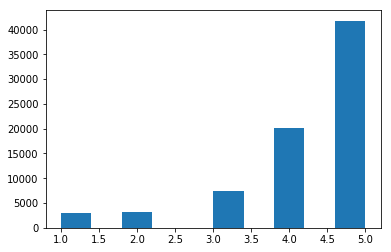

In [14]:
plt.hist(df['ratings'])

# 3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio

In [15]:
from surprise import Dataset,Reader
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId', 'productId', 'ratings']], reader)

In [16]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.3,random_state=1)

# 4. Build Popularity Recommender model.

In [17]:
from surprise import Dataset,Reader
from surprise import KNNWithMeans
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import cross_validate
from collections import defaultdict
from surprise import SVD

In [18]:
df.groupby('productId')['ratings'].mean().sort_values(ascending=False).head()
#average sorted product ratings

productId
B00LKG1MC8    5.0
B002IPHA1W    5.0
B002IKKFIC    5.0
B002IKLJU0    5.0
B002IKLJUU    5.0
Name: ratings, dtype: float64

In [19]:
ratings_mean_count=pd.DataFrame(df.groupby('productId')['ratings'].mean())

In [20]:
ratings_mean_count['rating_counts'] = pd.DataFrame(df.groupby('productId')['ratings'].count())
#creating new df with ratings mean count

In [21]:
ratings_mean_count.head()

,ratings,rating_counts
productId,,
0594481813,3.0,1
0970407998,2.5,2
0972683275,5.0,1
1400501466,2.0,2
1400501776,4.0,1


In [22]:
#Top 5 recommendation using popularity based model
ratings_mean_count.sort_values(['rating_counts'], ascending=[False]).head()

,ratings,rating_counts
productId,,
B0088CJT4U,4.213740,131
B003ES5ZUU,4.892157,102
B000N99BBC,4.755102,98
B002R5AM7C,4.193878,98
B00829TIEK,4.410526,95


# 5. Build Collaborative Filtering model.

In [23]:
algo = KNNWithMeans(k=50,sim_options={'name':'pearson_baseline','user_based': False})

In [24]:
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [25]:
#With KNNwithMeans model we get RMSE score as below
print("Item-based Model : Test Set")
accuracy.rmse(algo.test(testset), verbose=True)

Item-based Model : Test Set
RMSE: 1.1302


1.1302211574786107

In [26]:
#building SVD model for better accuracy in RMSE

In [27]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors' : [3,4,5,6,7,10,15], "reg_all":[0.03,0.04,0.05,0.06]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3,refit = True)

In [28]:
gs.fit(data)

In [29]:
gs.param_combinations

[{'n_factors': 3, 'reg_all': 0.03},
 {'n_factors': 3, 'reg_all': 0.04},
 {'n_factors': 3, 'reg_all': 0.05},
 {'n_factors': 3, 'reg_all': 0.06},
 {'n_factors': 4, 'reg_all': 0.03},
 {'n_factors': 4, 'reg_all': 0.04},
 {'n_factors': 4, 'reg_all': 0.05},
 {'n_factors': 4, 'reg_all': 0.06},
 {'n_factors': 5, 'reg_all': 0.03},
 {'n_factors': 5, 'reg_all': 0.04},
 {'n_factors': 5, 'reg_all': 0.05},
 {'n_factors': 5, 'reg_all': 0.06},
 {'n_factors': 6, 'reg_all': 0.03},
 {'n_factors': 6, 'reg_all': 0.04},
 {'n_factors': 6, 'reg_all': 0.05},
 {'n_factors': 6, 'reg_all': 0.06},
 {'n_factors': 7, 'reg_all': 0.03},
 {'n_factors': 7, 'reg_all': 0.04},
 {'n_factors': 7, 'reg_all': 0.05},
 {'n_factors': 7, 'reg_all': 0.06},
 {'n_factors': 10, 'reg_all': 0.03},
 {'n_factors': 10, 'reg_all': 0.04},
 {'n_factors': 10, 'reg_all': 0.05},
 {'n_factors': 10, 'reg_all': 0.06},
 {'n_factors': 15, 'reg_all': 0.03},
 {'n_factors': 15, 'reg_all': 0.04},
 {'n_factors': 15, 'reg_all': 0.05},
 {'n_factors': 15, 'r

In [30]:
gs.best_params

{'rmse': {'n_factors': 3, 'reg_all': 0.06}}

In [31]:
gs.test(testset)

[Prediction(uid='A3R1WFO4KIUQXZ', iid='B005ONMDYE', r_ui=5.0, est=4.391178329383856, details={'was_impossible': False}),
 Prediction(uid='A11EXFO14WEJM1', iid='B000816XJI', r_ui=5.0, est=4.45774712267029, details={'was_impossible': False}),
 Prediction(uid='A11OTLEDSW8ZXD', iid='B00E89AQDA', r_ui=3.0, est=4.106630349536464, details={'was_impossible': False}),
 Prediction(uid='A3PCEB9ND82AGE', iid='B008OX48XK', r_ui=5.0, est=4.821489616104908, details={'was_impossible': False}),
 Prediction(uid='ARBKYIVNYWK3C', iid='B004WIUDGM', r_ui=4.0, est=3.9899801954988523, details={'was_impossible': False}),
 Prediction(uid='A3LGT6UZL99IW1', iid='B005YQXMAK', r_ui=5.0, est=4.229982586749519, details={'was_impossible': False}),
 Prediction(uid='A3CEUT263RNUDO', iid='B004JK1VMS', r_ui=4.0, est=4.136607895652743, details={'was_impossible': False}),
 Prediction(uid='A1M7HP5CHDXXOU', iid='B00DB9WCR6', r_ui=5.0, est=4.60239222940536, details={'was_impossible': False}),
 Prediction(uid='A2QI2NTDTMK2FV', 

In [32]:
SVD_test_pred=gs.test(testset)
accuracy.rmse(SVD_test_pred)

RMSE: 0.8768


0.8767890620582096

# 7. Get top - K ( K = 5) recommendations.

In [33]:
def get_top_n(predictions, n):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [34]:
top_n = get_top_n(SVD_test_pred,5)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A3R1WFO4KIUQXZ ['B002V88HFE', 'B001UI2FPE', 'B003FVJYF8', 'B004YDUZ22', 'B00FSB76XA']
A11EXFO14WEJM1 ['B0041OSQ9I', 'B003M0NURK', 'B00691YKE6', 'B001EPVOQY', 'B000VEPC4O']
A11OTLEDSW8ZXD ['B002LTWDSK', 'B0079UAT0A', 'B00HMREOLK', 'B001DJ9GOS', 'B00CHR46JA']
A3PCEB9ND82AGE ['B007WTAJTO', 'B008OHNZI0', 'B00CU9GOAO', 'B00083LFW6', 'B0098HVXVQ']
ARBKYIVNYWK3C ['B0052SCU8U', 'B001C271MA', 'B007WTAJTO', 'B00267S7XW', 'B0090Z3QG6']
A3LGT6UZL99IW1 ['B000V5P90K', 'B004CLYEDC', 'B00009R6N0', 'B00HFFDDLG', 'B00JF0D7RE']
A3CEUT263RNUDO ['B00007GQLS', 'B001UI2FPE', 'B004CLYEDC', 'B004JMZPJQ', 'B009A6CZ30']
A1M7HP5CHDXXOU ['B00D5Q75RC', 'B008LTBITY', 'B00DB9WCR6', 'B003ZBZ64Q', 'B007Z419BI']
A2QI2NTDTMK2FV ['B0019EHU8G', 'B000IJV4BC', 'B001U0OGQS', 'B0001GRTK2', 'B000EXRSVM']
A1J75JJ0Q2OEJN ['B00834SJSK', 'B002M3SOC4', 'B000V01RLK', 'B008OEHPKM', 'B00834SJNA']
A1RJKTYC03L0JY ['B005LFT3GG', 'B00018U7KO', 'B00CE590Z0', 'B003XY6HYS', 'B00FRDUZUK']
A2EW01G2LNJN06 ['B0047T79M2', 'B007JF8FD8', 'B007ZSYHYU

# 8. Summarise your insights.

#1)we considered three columns userId, productId,ratings and dropped the timestamp column for this case .
#2)We analyzed the dataset and plotted the ratings,user based ratings and other needed info.
#3)To avoid memory issues we considered a subset of data(users who have given atleast 70product ratings).
#4)We implemented popularity based recommendations by listing out the higly rated products with the highest number of ratings.it is not unique to each user but popularity based recommendation is same regardless of the user.
#5)We implemented item based collaborative filtering model,as our area of interest is to provide product recommendations for the user.
#6)For the current work we used KNNwithmeans model and we got a test rmse of 1.13. For rating scale of 1-5, Rmse value 1.11 is too high to consider as a good model, hence tried SVD model too.
#7)so we tried implementing SVD and the rmse was 0.87 with the help of grid search.
#8)We formulated top 5 recommendations for each user using SVD parameter tuned model

